# Building Character Level Model using MLP
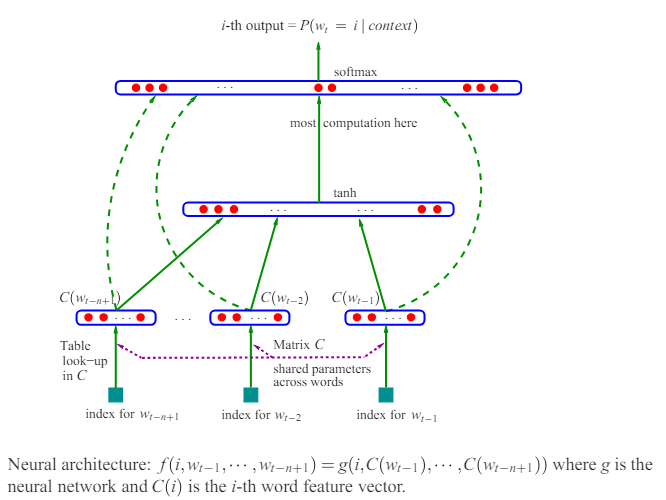

### Importing necessary libraries

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
import random
%matplotlib inline

In [2]:
words = open("./data/names.txt", "r").read().splitlines()
len(words)

32033

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Building the dataset considering the context window

In [4]:
block_size = 3
X, Y = [], []

for w in words[:5]:
    
    context = [0]*block_size
    for ch in w+'.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:]+[ix] #shift the context window and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

#### Getting the train, dev version of dataset as well

In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Embedding Matrix/ LookUp Table

In [8]:
## Let us consider we want to represent the embeddings in 2D space
## Vocabulory : Unique elements in the dataset is 27
## So Embedding Matrix Dimension : 27 X 2

g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27,2), generator = g)

In [9]:
C.shape

torch.Size([27, 2])

#### Getting the embedding for a particular character : Different ways

In [10]:
## Getting embedding via direct indexing 

emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [11]:
emb

tensor([[[0.7081, 0.3542],
         [0.7081, 0.3542],
         [0.7081, 0.3542]],

        [[0.7081, 0.3542],
         [0.7081, 0.3542],
         [0.7408, 0.4012]],

        [[0.7081, 0.3542],
         [0.7408, 0.4012],
         [0.2070, 0.6071]],

        [[0.7408, 0.4012],
         [0.2070, 0.6071],
         [0.2070, 0.6071]],

        [[0.2070, 0.6071],
         [0.2070, 0.6071],
         [0.1054, 0.5996]],

        [[0.7081, 0.3542],
         [0.7081, 0.3542],
         [0.7081, 0.3542]],

        [[0.7081, 0.3542],
         [0.7081, 0.3542],
         [0.5998, 0.1621]],

        [[0.7081, 0.3542],
         [0.5998, 0.1621],
         [0.9928, 0.3419]],

        [[0.5998, 0.1621],
         [0.9928, 0.3419],
         [0.9600, 0.4388]],

        [[0.9928, 0.3419],
         [0.9600, 0.4388],
         [0.6008, 0.1163]],

        [[0.9600, 0.4388],
         [0.6008, 0.1163],
         [0.9600, 0.4388]],

        [[0.6008, 0.1163],
         [0.9600, 0.4388],
         [0.1054, 0.5996]],

    

In [12]:
## Getting the embedding from the matrix multiplication of one-hot vectors and Embedding Matrix

emb = F.one_hot(X, num_classes = 27).float()@C
emb.shape

torch.Size([32, 3, 2])

In [13]:
emb

tensor([[[0.7081, 0.3542],
         [0.7081, 0.3542],
         [0.7081, 0.3542]],

        [[0.7081, 0.3542],
         [0.7081, 0.3542],
         [0.7408, 0.4012]],

        [[0.7081, 0.3542],
         [0.7408, 0.4012],
         [0.2070, 0.6071]],

        [[0.7408, 0.4012],
         [0.2070, 0.6071],
         [0.2070, 0.6071]],

        [[0.2070, 0.6071],
         [0.2070, 0.6071],
         [0.1054, 0.5996]],

        [[0.7081, 0.3542],
         [0.7081, 0.3542],
         [0.7081, 0.3542]],

        [[0.7081, 0.3542],
         [0.7081, 0.3542],
         [0.5998, 0.1621]],

        [[0.7081, 0.3542],
         [0.5998, 0.1621],
         [0.9928, 0.3419]],

        [[0.5998, 0.1621],
         [0.9928, 0.3419],
         [0.9600, 0.4388]],

        [[0.9928, 0.3419],
         [0.9600, 0.4388],
         [0.6008, 0.1163]],

        [[0.9600, 0.4388],
         [0.6008, 0.1163],
         [0.9600, 0.4388]],

        [[0.6008, 0.1163],
         [0.9600, 0.4388],
         [0.1054, 0.5996]],

    

### Hidden Layers and Activations

In [14]:
## We want to compute something like: 
## emb @ W1 + b1
## The 1st dimension of the Weight matrix will thus be 3 x 2 = 6 

g = torch.Generator().manual_seed(2147483647)
W1 = torch.rand((6,100), generator = g)
b1 = torch.rand(100, generator = g)

In [15]:
## Now for logits = emb@W1+b1, the multiplication of emb@W1 should be possible
## So we need to stack the 3 x 2 dimension into one dimension 6
## There are several ways of doing this: torch.cat, torch.view
## It is always advised to use torch.view instead

# Using torch.cat
emb_cat = torch.cat((emb[:,0,:], emb[:,1,:], emb[:,2,:]), dim = 1)
print(f"Dimension of emb-cat : {emb_cat.shape}")

## However using torch.cat we need to know the context window beforehand, is there an automatic way of removing a dimension - torch.unbind()
emb_unbind = torch.cat(torch.unbind(emb, 1), dim = 1)
print(f"Dimension of emb-unbind : {emb_unbind.shape}")

## Using view :  View is way more efficient as this is an inplace operation
## In views you can just use -1 as the first dimension, as torch will automatically infer the dimension
emb_view = emb.view(-1, 6)
print(f"Dimension of emb-unbind : {emb_view.shape}")

Dimension of emb-cat : torch.Size([32, 6])
Dimension of emb-unbind : torch.Size([32, 6])
Dimension of emb-unbind : torch.Size([32, 6])


In [16]:
hidden = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2])@W1 + b1)
hidden.shape

torch.Size([32, 100])

In [17]:
hidden

tensor([[0.9580, 0.9650, 0.9758,  ..., 0.9821, 0.9591, 0.9928],
        [0.9627, 0.9676, 0.9776,  ..., 0.9838, 0.9610, 0.9937],
        [0.9630, 0.9507, 0.9725,  ..., 0.9668, 0.9548, 0.9902],
        ...,
        [0.9838, 0.9745, 0.9837,  ..., 0.9784, 0.9603, 0.9955],
        [0.9876, 0.9789, 0.9944,  ..., 0.9937, 0.9766, 0.9957],
        [0.9874, 0.9665, 0.9918,  ..., 0.9869, 0.9752, 0.9945]])

In [18]:
g = torch.Generator().manual_seed(2147483647)
W2 = torch.rand((100,27), generator = g)
b2 = torch.rand(27, generator = g)

### From activations to getting loss

In [19]:
logits = hidden@W2 + b2
counts = logits.exp()
probs = counts/counts.sum(dim = 1, keepdims = True)
probs.shape

torch.Size([32, 27])

In [20]:
prob = probs[torch.arange(32), Y]

In [21]:
### Negative Log likelihood loss
loss = -prob.log().mean()
loss.item()

6.6793131828308105

#### Using Cross Entropy for loss
- This is required because cross_entropy is very efficient
- Incase the logits have high positive values, when we do logits.exp -> it might explode and you may get a nan as output
- Pytorch overcomes this by reducing each element by the max value within the tensor, as this op does not change the value of softmax
- Internally fused kernels are used to perform these opperations which are very efficient
- Mathematically it becomes effiecient when we group a lot of operations especially the backprop -look backprop of tanh in scalar autograd

In [22]:
loss = F.cross_entropy(logits, Y)
loss.item()

6.679312705993652

### Summarizing everything and starting the training

In [23]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [24]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [25]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [26]:
for p in parameters:
    p.requires_grad = True

In [27]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri, lossi, stepi = [], [], []

#### Training using gradient descent

In [28]:
for i in range(200000):
  
    # minibatch construct - Here it will give a batch of 32 samples
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = F.one_hot(Xtr[ix], num_classes = 27).float()@C # (32, 3, 10)
    h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    # Update the parameters
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

#print(loss.item())

#### Loss against steps

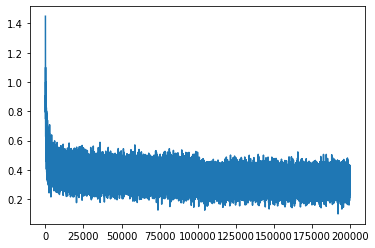

In [29]:
plt.plot(stepi, lossi)

#### Train loss vs Dev loss

In [30]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
tr_loss = F.cross_entropy(logits, Ytr)

emb = C[Xdev]
h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev)

print(f'Train loss: {tr_loss}, Dev loss: {dev_loss}')

Train loss: 2.131976842880249, Dev loss: 2.1722323894500732


#### Visualize dimensions 0 and 1 of the embedding matrix C for all characters

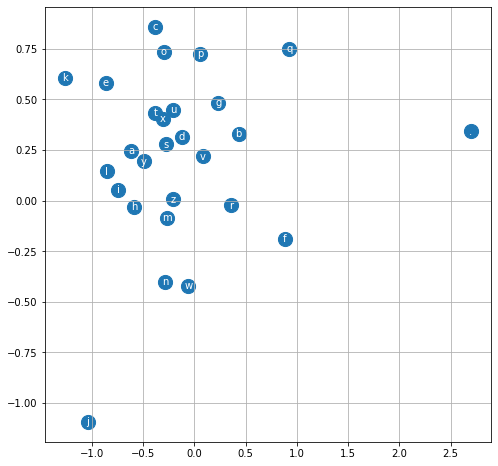

In [31]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

### Sample from this Character Level Neural Network Model

In [32]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out, context_size = [], 3
    context = [0]*context_size
    
    while(True):
        
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, emb.shape[1]*emb.shape[2]) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1, generator = g).item()
        context = context[1:]+[ix]
        ch = itos[ix]
        out.append(ch)
        
        if ch == '.':
            print(''.join(out))
            break

cerie.
coullie.
rochukahnell.
imittainella.
kama.
da.
samiyah.
javariiot.
shid.
jenatho.
keitedoren.
emiless.
suettavion.
hatls.
milline.
viah.
asu.
dyde.
breenley.
alaisan.
